`cd project/seniorthesis/notebooks`

`conda list PyCO2SYS`

`pip install PyCO2SYS`

`mamba update cmip6_preprocessing -y`

In [1]:
import xarray as xr
from cmip6_preprocessing.preprocessing import combined_preprocessing
import PyCO2SYS as pyco2 # i have to install this package through terminal for it to work
import intake
import matplotlib.pyplot as plt
import numpy as np
import warnings
import gsw
from cmip6_preprocessing.postprocessing import combine_datasets
warnings.filterwarnings("ignore")

In [2]:
col = intake.open_esm_datastore("https://storage.googleapis.com/cmip6/pangeo-cmip6.json")

In [20]:
def pick_first_member(ds_list, **kwargs):
    return ds_list[0]

variables = ['dissic','talk','so','thetao']
z_kwargs = {'consolidated': True, 'use_cftime': True}
query = dict(experiment_id=['historical'], table_id=['Omon'], 
             variable_id=variables,
             grid_label=['gr'],
             source_id=['GFDL-ESM4',
                        'CESM2-FV2','CESM2','MRI-ESM2-0',
                        'CESM2-WACCM-FV2','GFDL-CM4','CESM2-WACCM',
                        'E3SM-1-1-ECA'])
cat = col.search(**query)

# this doesn't work??? it ends up making temp empty 
# grouped = cat.df.groupby(cat.groupby_attrs)
# cat.df = grouped.first().reset_index()

# print(cat.df['source_id'].unique())
dset_dict_old = cat.to_dataset_dict(zarr_kwargs=z_kwargs, storage_options={'token': 'anon'},
                                preprocess=combined_preprocessing, aggregate=True)



--> The keys in the returned dictionary of datasets are constructed as follows:
	'activity_id.institution_id.source_id.experiment_id.table_id.grid_label'


In [21]:
dset_dict = dset_dict_old
dset_dict

{'CMIP.E3SM-Project.E3SM-1-1-ECA.historical.Omon.gr': <xarray.Dataset>
 Dimensions:        (bnds: 2, lev: 60, member_id: 1, time: 1980, vertex: 4, x: 360, y: 180)
 Coordinates:
   * y              (y) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
     lat_bounds     (y, bnds, x) float64 dask.array<chunksize=(180, 2, 360), meta=np.ndarray>
   * lev            (lev) float64 5.0 15.0 25.0 ... 4.875e+03 5.125e+03 5.375e+03
     lev_bounds     (lev, bnds) float64 dask.array<chunksize=(60, 2), meta=np.ndarray>
   * x              (x) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
     lon_bounds     (x, bnds, y) float64 dask.array<chunksize=(360, 2, 180), meta=np.ndarray>
   * time           (time) object 1850-01-16 12:00:00 ... 2014-12-16 12:00:00
     time_bounds    (time, bnds) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
   * bnds           (bnds) int64 0 1
     lon            (x, y) float64 0.5 0.5 0.5 0.5 ... 359.5 359.5 359.5 359.5
     lat            (x,

In [23]:
temp={}
for name,item in dset_dict.items():
    #print(name)
    #print(item.data_vars)
    present = item.data_vars
    if all(i in present for i in variables):
        #print(name)
        temp[name]=dset_dict[name]
dset_dict = temp


### Error in aggregation for 3 models
> `'E3SM-1-1'`

> `'E3SM-1-0'`

> `'NorCPM1'`

In [ ]:
# #variables = ['dissic','talk','so','thetao']
# z2_kwargs = {'consolidated': True, 'decode_times':False}
# query2 = dict(experiment_id=['historical'], table_id=['Omon'], 
#              variable_id=variables,
#              grid_label=['gr'],
#              source_id=['E3SM-1-1','E3SM-1-0','NorCPM1'])
# cat2 = col.search(**query2)
# # print(cat.df['source_id'].unique())
# dset_dict2 = cat2.to_dataset_dict(zarr_kwargs=z2_kwargs, storage_options={'token': 'anon'},preprocess=combined_preprocessing)

`results = pyco2.sys(par1=None, par2=None, par1_type=None, par2_type=None, **kwargs)`

### Arguments

`par1` and `par2`: values of two different carbonate system parameters.

`par1_type` and `par2_type`: which types of parameter par1 and par2 are.


Total alkalinity (type `1`) in μmol·kg−1.
> <font color='red'>alkalinity in CMIP6 is in mol/m3 </font> 

Dissolved inorganic carbon (type `2`) in μmol·kg−1.
> <font color='red'>DIC in CMIP6 is in mol/m3 </font> 

pH (type `3`) on the Total, Seawater, Free or NBS scale1. Which scale is given by the argument opt_pH_scale.

Partial pressure of CO2 (type `4`) in μatm, Fugacity of CO2 (type `5`) in μatm, Aqueous CO2 (type `8`) in μmol·kg−1, or Dry mole fraction of CO2 (type `9`) in ppm.

Carbonate ion (type `6`) in μmol·kg−1.

Bicarbonate ion (type `7`) in μmol·kg−1.

### Kwargs/hydrographic conditions

`salinity`: practical salinity (dimensionless).

`temperature`: temperature at which `par1` and `par2` arguments are provided in °C (default 25 °C).
> <font color='red'>in situ temp </font> 
> `gsw.t_from_CT(SA, CT, p)`

`pressure`: water pressure at which `par1` and `par2` arguments are provided in dbar (default 0 dbar).
> pressure_in will be related to depth

> `gsw.p_from_z(z, lat, geo_strf_dyn_height=0, sea_surface_geopotential=0)` = dbar

> > Parameters

> > > zarray-like: Depth, positive up, m

> > > latarray-like: Latitude, -90 to 90 degrees

> > > geo_strf_dyn_heightarray-like

> > > > dynamic height anomaly, m^2/s^2

> > > > Note that the reference pressure, p_ref, of geo_strf_dyn_height must be zero (0) dbar.

> > > sea_surface_geopotentialarray-like

> > > > geopotential at zero sea pressure, m^2/s^2

> > Returns

> > > parray-like, dbar

> > > > sea pressure ( i.e. absolute pressure - 10.1325 dbar )


`temperature_out`: temperature at which results will be calculated in °C ("output conditions").
> <font color='red'>temperature_out = thetao (potential temp) </font> 

`pressure_out`: water pressure at which results will be calculated in dbar ("output conditions").
> <font color='red'>pressure out should be 0 since raised to surface </font> 

### Results (non-exhaustive but some that looked relevant)

`"dic"`: dissolved inorganic carbon in μmol·kg−1.

`"aqueous_CO2"/"aqueous_CO2_out"`: aqueous CO2 at input/output conditions in μmol·kg−1.

`"pCO2"/"pCO2_out"`: seawater partial pressure of CO2 at input/output conditions in μatm.

`"alkalinity"`: total alkalinity in μmol·kg−1.

`"pH"/"pH_out"`: pH at input/output conditions on the scale specified by input opt_pH_scale.

`"pH_total"/"pH_total_out"`: pH at input/output conditions on the Total scale.

#### convert potential temperature to conservative temperature


In [53]:

def calc_PpCO2_graeme(ds):
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure=0)
    return ds['talk'].copy(data=results['pCO2'])

def calc_PpCO2(ds):
    p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
    insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)  # 0 is just a filler rn 
    results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = p, 
                        temperature = insitutemp)
    return ds['talk'].copy(data=results['pCO2_out'])

def meridionalsection(ax,da,clims=None,title=None):
    im = ax.pcolormesh(da['y'],da['lev'],da)
    if clims is not None:
        im.set_clim(clims)
    ax.set_xlim([-80,60])
    ax.invert_yaxis()
    plt.colorbar(im,ax=ax)
    ax.set_title(title)
    
def calc_sigma2(ds):
    return gsw.sigma2(ds['so'],ds['thetao'])

def meridionalsection_with_sigma2(ax,da,sigma2,clims=None,title=None):
    meridionalsection(ax,da,clims)
    ax.contour(da['y'],da['lev'],sigma2,levels=[36,36.4,36.8],colors='w')
    ax.set_title(title)

### Clearly, something is wrong, since nothing shows up in the figure. First issue I identified is in the calculation of p, which I don't know how to fix

In [ ]:
n = len(dset_dict.items())
fig, axarr = plt.subplots(nrows=n,figsize=[10,3*n])
for ax,(k, ds) in zip(axarr.flat,dset_dict.items()):
    ds = ds.isel(time=1200).sel(x=slice(180,200)).mean('x',keep_attrs=True)
    if 'member_id' in ds.dims:
        ds = ds.isel(member_id=0)
    pco2 = calc_PpCO2(ds)
    #sigma2 = calc_sigma2(ds)
    meridionalsection_with_sigma2(ax,pco2,sigma2,clims=[0,2000],title=ds.attrs['intake_esm_dataset_key'])

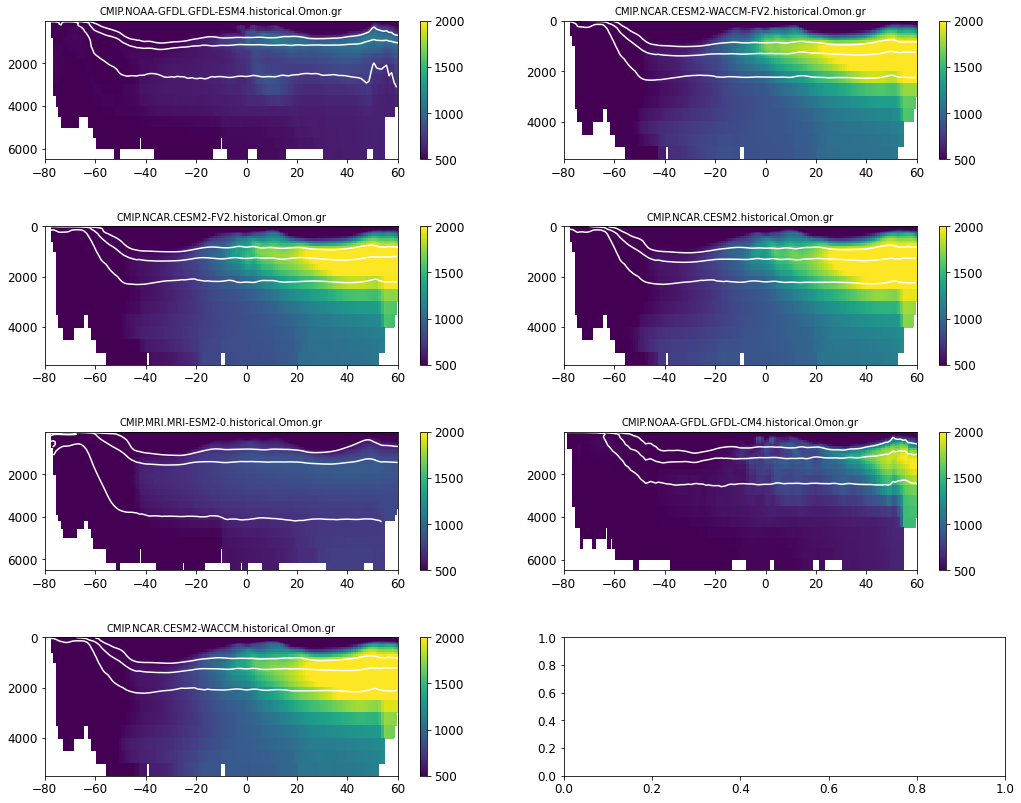

In [55]:
# fig, ax = plt.subplots(figsize=[10,3])
# ds = dset_dict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
# if 'member_id' in ds.dims:
#     ds = ds.isel(member_id=0)
# pco2 = calc_PpCO2(ds)
# #sigma2 = calc_sigma2(ds)
# meridionalsection(ax,pco2,clims=[0,1000],title=ds.attrs['intake_esm_dataset_key'])

#You dont have to spell out all the axes, you can just keep them in an array
fig_pco2, axarr_pco2 = plt.subplots(nrows = 4, ncols = 2, figsize=[15,12])
fig_pco2.tight_layout(pad = 3.5)
plt.rc('font', size = 12)
plt.rc('axes', titlesize= 10)    
plt.rc('axes', labelsize= 10)
plt.rc('figure', titlesize=14)

#loop over each key, value pair of the dictionary
ax_idx = 0 # index for your axes array
for name, ds_pco2 in dset_dict.items():
    ax = axarr_pco2.flat[ax_idx]
    ds_pco2 = ds_pco2.isel(time=1200).sel(x=slice(180,200)).mean('x',keep_attrs=True)
    if 'member_id' in ds_pco2.dims:
        if name == 'CMIP.MRI.MRI-ESM2-0.historical.Omon.gr':
            ds_pco2 = ds_pco2.isel(member_id=1)
        elif name == 'CMIP.NCAR.CESM2.historical.Omon.gr':
            ds_pco2 = ds_pco2.isel(member_id=2)
        else:
            ds_pco2 = ds_pco2.isel(member_id=0)
    pco2 = calc_PpCO2(ds_pco2)
    sigma2 = calc_sigma2(ds_pco2)
    meridionalsection_with_sigma1(ax,pco2,sigma2, clims=[500,2000],title=ds_pco2.attrs['intake_esm_dataset_key'])
    ax_idx += 1 # this is a nifty python trick to increment a variable by one

# for name, ds_pco2 in dset_dict.items():
#     ds_pco2 = ds_pco2.isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
#     if 'member_id' in ds_pco2.dims:
#         if name == 'CMIP.NCAR.CESM2.historical.Omon.gr':
#             ds_pco2 = ds_pco2.isel(member_id=2)
#             pco2 = calc_PpCO2(ds_pco2)
#             print(pco2)



<xarray.DataArray 'talk' (member_id: 11, lev: 33, y: 180)>
array([[[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        ...,
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan]],

       [[         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,          nan,
                  nan,          nan],
        [         nan,          nan,          nan, ...,       

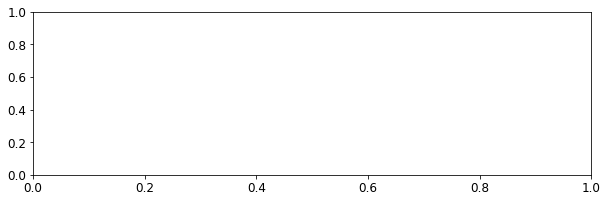

In [39]:
fig, ax = plt.subplots(figsize=[10,3])
ds = dset_dict['CMIP.NCAR.CESM2.historical.Omon.gr'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)
results = pyco2.sys(par1=ds['talk']*1035.0,par2=ds['dissic']*1035.0,par1_type=1,par2_type=2,
                        pressure_out=0, temperature_out = ds['thetao'], pressure = p, 
                        temperature = insitutemp)
print(ds['talk'].copy(data=results['pCO2_out']))
# if 'member_id' in ds.dims:
#     ds = ds.isel(member_id=0)
# pco2 = calc_PpCO2(ds)
# #sigma2 = calc_sigma2(ds)
# meridionalsection(ax,pco2,clims=[0,1000],title=ds.attrs['intake_esm_dataset_key'])

#### I'm not sure why pressure is only being calculated for the first depth and none of the others

In [10]:
ds = dset_dict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
p = gsw.p_from_z(-1*ds['lev'], ds['y'], geo_strf_dyn_height=0, sea_surface_geopotential=0)
p

<xarray.DataArray 'lev' (lev: 35, y: 180)>
array([[2.52714941e+00, 2.52714125e+00, 2.52712495e+00, ...,
        2.52712495e+00, 2.52714125e+00, 2.52714941e+00],
       [1.01087837e+01, 1.01087511e+01, 1.01086859e+01, ...,
        1.01086859e+01, 1.01087511e+01, 1.01087837e+01],
       [2.02180635e+01, 2.02179983e+01, 2.02178679e+01, ...,
        2.02178679e+01, 2.02179983e+01, 2.02180635e+01],
       ...,
       [5.63244231e+03, 5.63242392e+03, 5.63238717e+03, ...,
        5.63238717e+03, 5.63242392e+03, 5.63244231e+03],
       [6.15144542e+03, 6.15142532e+03, 6.15138514e+03, ...,
        6.15138514e+03, 6.15142532e+03, 6.15144542e+03],
       [6.67156355e+03, 6.67154172e+03, 6.67149810e+03, ...,
        6.67149810e+03, 6.67154172e+03, 6.67156355e+03]])
Coordinates:
  * lev      (lev) float64 2.5 10.0 20.0 32.5 ... 5e+03 5.5e+03 6e+03 6.5e+03
    time     int64 0
  * y        (y) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5

#### Obvi this result is unreliable as long as p is wrong

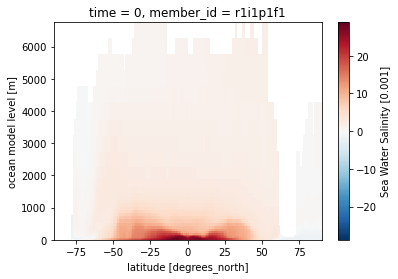

In [18]:
ds = dset_dict['CMIP.NOAA-GFDL.GFDL-ESM4.historical.Omon.gr'].isel(time=0).sel(x=slice(180,200)).mean('x',keep_attrs=True)
insitutemp = gsw.t_from_CT(ds['so'], ds['thetao'], p)
insitutemp.plot()